In [19]:
import xarray as xr
import earthaccess
from datetime import datetime, timezone

In [27]:
auth = earthaccess.login(strategy="interactive")  # Prompts for username and password
if auth:
    print("Login successful!")
else:
    print("Login failed.")

auth 

Login successful!


In [29]:

# Search for a near-real-time sea ice dataset
search_results = earthaccess.search_data(
    short_name="NSIDC-0081 ",  # Example: Near-Real-Time SSMIS Daily Sea Ice
)
search_results

[]

In [9]:
files = earthaccess.open(search_results)
files

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/OTHR/NISE.005/2025.01.22/NISE_SSMISF18_20250122.HDFEOS>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/OTHR/NISE.004/2025.01.22/NISE_SSMISF17_20250122.HDFEOS>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/OTHR/NISE.003/2025.01.22/NISE_SSMISF16_20250122.HDFEOS>]

In [35]:
ds = xr.open_dataset('engice.t00z.grb.grib2', engine='cfgrib', backend_kwargs={'indexpath': None})
ds 

<xarray.Dataset> Size: 1MB
Dimensions:     (latitude: 360, longitude: 720)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    meanSea     float64 8B ...
  * latitude    (latitude) float64 3kB 89.75 89.25 88.75 ... -89.25 -89.75
  * longitude   (longitude) float64 6kB 0.25 0.75 1.25 ... 358.8 359.2 359.8
    valid_time  datetime64[ns] 8B ...
Data variables:
    unknown     (latitude, longitude) float32 1MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-01-23T12:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [36]:
max = ds['unknown'].max().values

FunctionalityNotEnabledError: Functionality not enabled

In [1]:
from meteostream.noaa_crw import get_latest_CRW_data

In [38]:
ds = get_latest_CRW_data()
ds 

<xarray.Dataset> Size: 415MB
Dimensions:     (latitude: 3600, longitude: 7200)
Coordinates:
  * latitude    (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude   (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
    time        datetime64[ns] 8B 2025-01-21T12:00:00
Data variables:
    CRW_SEAICE  (latitude, longitude) float64 207MB dask.array<chunksize=(303, 606), meta=np.ndarray>
    CRW_SST     (latitude, longitude) float64 207MB dask.array<chunksize=(303, 606), meta=np.ndarray>
Attributes: (12/60)
    acknowledgement:                 NOAA Coral Reef Watch (CRW)
    cdm_data_type:                   Grid
    comment:                         This product is designed to improve on a...
    Conventions:                     CF-1.6, ACDD-1.3
    creator_email:                   coralreefwatch@noaa.gov
    creator_institution:             NOAA Coral Reef Watch (CRW)
    ...                              ...
    locations_vocabulary:            GCMD Location Keywords
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         0.0
    geospatial_vertical_units:       meters
    geospatial_vertical_positive:    up
    geospatial_vertical_resolution:  0.0

In [3]:
ds.to_netcdf("test.nc")

In [39]:
ds = ds.sel(latitude=slice(60, 40), longitude=slice(-70, -50))

c:\Users\Tyler\work-repos\meteostream\.venv\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


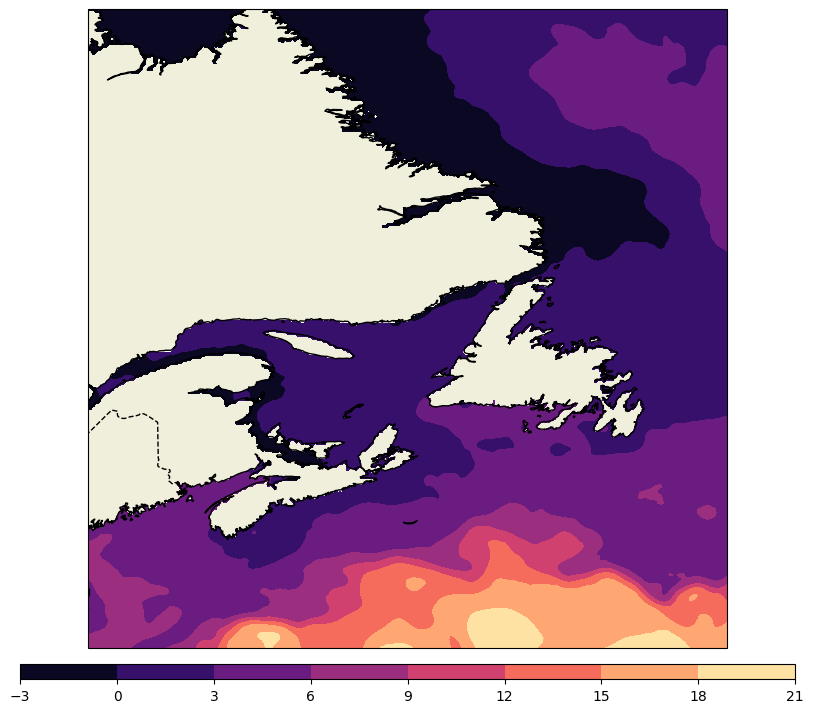

In [41]:
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg
import cartopy.crs as ccrs
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ice = ds['CRW_SST']

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))

ax.add_feature(cfeature.LAND, zorder=0)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), zorder=2, color='black')
ax.add_feature(cfeature.BORDERS, linestyle='--', zorder=3)

cf = ax.contourf(ice['longitude'].values, ice['latitude'].values, ice.values, cmap='magma', zorder=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.02, aspect=50)


In [2]:
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg
import cartopy.crs as ccrs
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

REGIONS = {
        'Baltic_Sea': ([15, 32, 54, 66], ccrs.PlateCarree()),
        'Hokkaido': ([134, 151, 37, 49], ccrs.PlateCarree()),
        'St_Lawrence': ([-65, -49, 43, 55], ccrs.PlateCarree()),
        'Kurils(Okhotsk)': ([140, 160, 45, 60], ccrs.PlateCarree()),
        'Bering_Strait' : ([175, -165, 60, 75], ccrs.PlateCarree(central_longitude=180)),
        'Sea_of_Japan': ([124, 141, 36, 48], ccrs.PlateCarree()),
}

# CF LEVELS SETTINGS
CF_LEVELS_SST = list(range(-2, 34, 2))
CF_LEVELS_ICE = np.arange(0, 1.10, 0.10)
TRANSFORM = ccrs.PlateCarree()


def set_fig_title(fig, region_name, time):
    '''
    Set the title for each plot

    Args:
    ax: Axes object
    region_name: Name of the region
    time: Time string

    Returns:
    None

    '''

    fig.suptitle(f'{region_name}\n Valid: {time} UTC')

def plot_data():
    '''
    Plot the data for each region

    '''
    logo = mpimg.imread('/home/tylerradebaugh/IceChart/src/utils/logos/AMI_logo.png')
    logo = mpimg.imread('/home/tylerradebaugh/IceChart/src/utils/logos/AMI_logo.png')


    for region_name, (extent, projection) in REGIONS.items():
        fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})

        # Create an inset axis anchored to the parent axis 'ax'
        ax_inset = inset_axes(ax, width="15%", height="15%", loc='upper left', borderpad=0.5)

        # Add the logo to the inset axis
        ax_inset.imshow(logo)
        ax_inset.axis('off')  # Turn off the axis for the inset logo

        # Set the extent (bounding box) of the map
        ax.set_extent(extent)
        
        # Add features such as coastlines and gridlines
        ax.add_feature(cfeature.LAND, edgecolor='face', facecolor='silver')
        ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.50)
        gl = ax.gridlines(draw_labels=True, zorder=5)
        gl.bottom_labels = False
        gl.right_labels = False

        gl.xlocator = mticker.MultipleLocator(5)
        gl.ylocator = mticker.MultipleLocator(2.5)

        gl.xlabel_style = {'size': 8}  # Set the font size for longitude labels
        gl.ylabel_style = {'size': 8}  # Set the font size for latitude labels
  

        try:
            ds = get_latest_CRW_data()

            # Slice the data based on the region and time
            ds = ds.sel(longitude = slice(extent[0], extent[1]), 
                        latitude = slice(extent[3], extent[2]))
            
            ice = ds['CRW_SEAICE']
            sst = ds['CRW_SST']

            time = ice['time'].values

            # Set the title for each plot
            set_fig_title(fig, region_name, time)

            # Plot the data
            ice_cf = ax.contourf(ice['longitude'].values, ice['latitude'].values, ice.values, cmap='Blues_r', levels=CF_LEVELS_ICE)
            sst_cf = ax.contourf(sst['longitude'].values, sst['latitude'].values, sst.values, cmap='magma', levels=10, extend='both')


            cbar_ax = fig.add_axes([0.91, 0.1, 0.02, 0.78])
            cbar = plt.colorbar(sst_cf, cax=cbar_ax, orientation='vertical', label='Sea Surface Temperature (°C)', pad=0.005, aspect=30, shrink=0.85)


            ice_cbar_ax = fig.add_axes([0.125, 0.08, 0.77, 0.02])
            ice_cbar = plt.colorbar(ice_cf, cax=ice_cbar_ax, orientation='horizontal', label='Sea Ice Concentration (%)', pad=0.0075, aspect=30, shrink=0.85)
            ice_cbar.set_ticks(CF_LEVELS_ICE)  # Set ticks based on the actual data range
            ice_cbar.set_ticklabels(['0', '10', '20', '30','40', '50', 
                                 '60', '70', '80', '90', '100']) # Set tick labels based on the actual data 
        
        except Exception as e:
            print(f'Error plotting data for {region_name}: {e}')
            continue
        
          
        #plt.savefig(f'/home/vrsops/Ops-Scripts/iceChart/examples/{region_name}_{hour}z.png')
        plt.savefig(f'sice_{region_name}_{time}z.png')
        
        ds.close()

KeyboardInterrupt: 

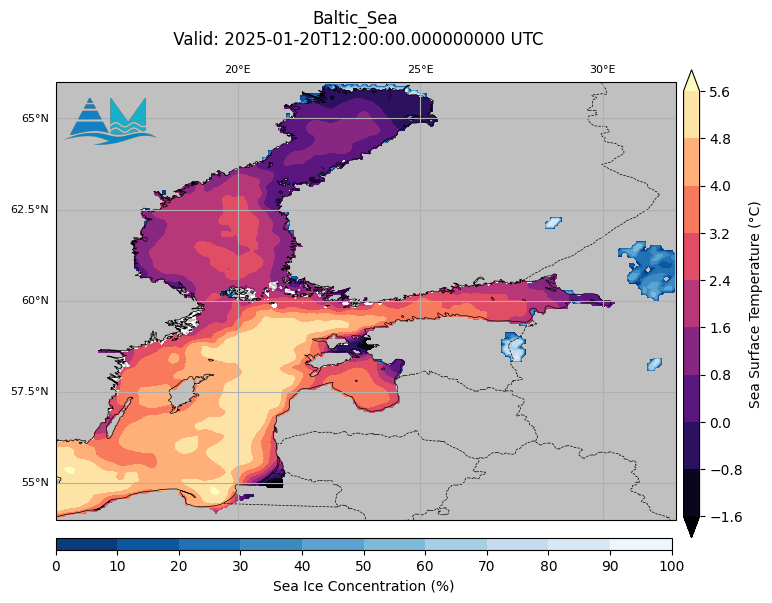

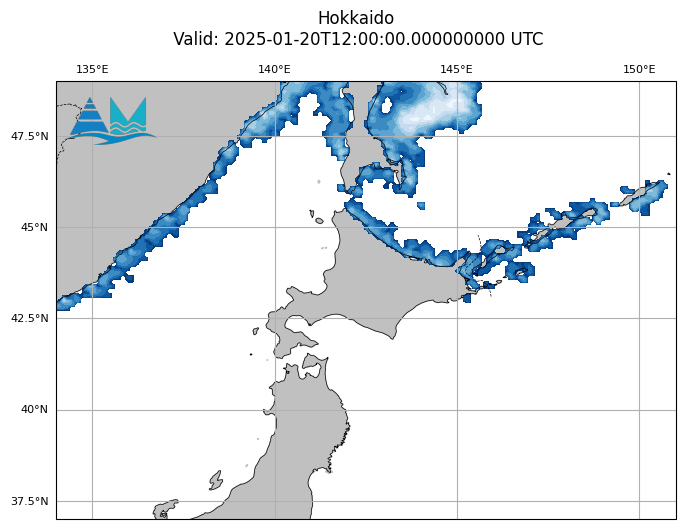

In [3]:
plot_data()

In [2]:
import cdsapi

# Initialize the CDS API client
c = cdsapi.Client()

# Construct the request
c.retrieve(
    'satellite-sea-ice-concentration',
    {
        'format': 'grib',  # Specify output format (e.g., GRIB or NetCDF)
        'product_type': 'reanalysis',  # Use appropriate type (e.g., reanalysis, observations)
        'time': 'latest',  # Automatically request the latest available data
        'variable': 'sea_ice_concentration',  # Variable of interest
    },
    'latest_sea_ice.grib'  # Save the latest data to this file
)

2025-01-22 22:22:42,281 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2025-01-22 22:22:42,283 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-22 22:22:42,283 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2025-01-22 22:22:42,284 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

HTTPError: 400 Client Error: Bad Request for url: https://cds.climate.copernicus.eu/api/retrieve/v1/processes/satellite-sea-ice-concentration/execution
invalid request
Request has not produced a valid combination of values, please check your selection.
{'product_type': 'reanalysis', 'time': 'latest', 'variable': 'sea_ice_concentration'}